# Feature Contributions Documentation

This notebook is designed to demonstrate how to use `pymint` to compute feature contributions using [SHAP](https://github.com/slundberg/shap) or [treeinterpreter](https://github.com/andosa/treeinterpreter) and plot the results. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook. In this set of examples, we will demostrate using feature contributions for a single example and summarize a set of examples by model performance.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)

In [2]:
import pymint
import plotting_config 
import shap
from pymint.common.utils import get_indices_based_on_performance, avg_and_sort_contributions

### Loading the training data and pre-fit models 

In [3]:
estimators, estimator_names = pymint.load_models()
X,y = pymint.load_data()

### Tree Interpreter-Based Feature Contribution (Single Example)

For decision trees models trained from the scikit-learn package, we can calculate feature contributions using the treeinterpreter method. The idea is that starting from the climatological event frequency of a dataset (AKA the "bias", 39% in our case), each split made in the decision path adds to or substracts from the bias to produce the final prediction. For an ensemble method like random forests, we can compute the contributions per tree and then take the ensemble average contribution. In our first example, we can get the contribution break-down for a single example for the random forest model (tree interpreter doesn't work for gradient-boosted models).

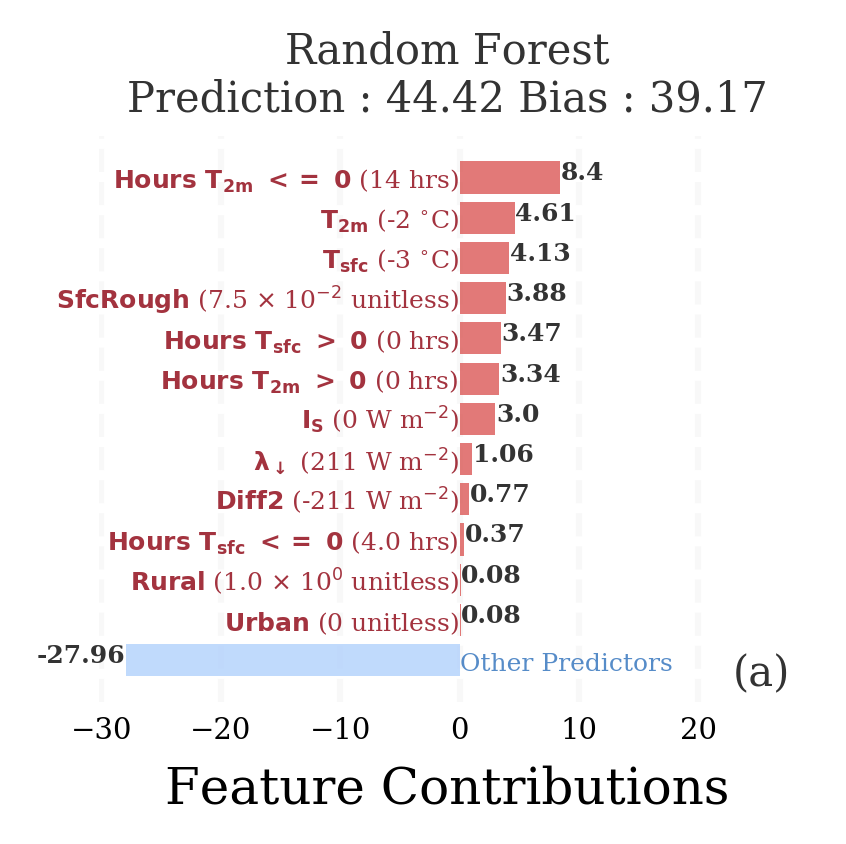

In [4]:
single_example = X.iloc[[0]]

explainer = pymint.InterpretToolkit(estimators[0],estimator_names=estimator_names[0], X=single_example,)
contrib_ds = explainer.local_contributions(method='tree_interpreter')

fig, axes = explainer.plot_contributions(
    contrib = contrib_ds, 
    display_feature_names=plotting_config.display_feature_names,
    display_units = plotting_config.display_units,
    wspace=0.1
)

`Prediction` is the final prediction for this example while `Bias` is the bias. The idea is that the summation of the contributions plus the bias will equal the final prediction. For this particular example, there are competing effects. 

## Tree Interpreter-Based Feature Contribution (Performance-Based)

Although it can be important to assess the breakdown of a single prediction, we can also summarize feature contributions over several examples. By setting `performance_based=True`, we can summarize feature contributions for the top and worst performers. The number of examples to compute these summarized statistics is given by `n_examples`. In this case, we want to summarize the contributions over top 100 best and worst performing examples. 

__Note__: "Hits" and "Misses" are defined as a set of predictions being close to or far from the target variables (binary or regression), respectively, and "Correct Negatives (Corr Negs)" and "False Alarms" are defined as a set of predictions being close to or far from the 


In [5]:
perf_keys = ["Best Hits",
             "Worst False Alarms", 
             "Worst Misses",
            ]
explainer = pymint.InterpretToolkit(estimators[0],estimator_names=estimator_names[0], X=X, y=y,)
tree_results = explainer.local_contributions(method='tree_interpreter', 
                                           performance_based=True,
                                           n_samples=10)
tree_results

,,dllwave_flux_contrib,dwpt2m_contrib,fric_vel_contrib,gflux_contrib,high_cloud_contrib,lat_hf_contrib,low_cloud_contrib,mid_cloud_contrib,sat_irbt_contrib,sens_hf_contrib,...,vdd_flux_val,wind10m_val,date_marker_val,urban_val,rural_val,d_ground_val,d_rad_d_val,d_rad_u_val,hrrr_dT_val,Bias_val
Best Hits,Random Forest,0.884704,3.405299,0.087890,0.232230,0.007855,0.216460,0.005088,0.007446,1.230687,0.705151,...,17.0495,4.6197,25.6,0.0,1.0,42.4,-203.01,-256.410,5.54605,0.0
Worst Misses,Random Forest,0.301792,-1.322826,0.459074,0.713872,0.154153,0.376347,0.276457,0.163186,0.103336,0.427145,...,39.0120,4.8066,41.9,0.1,0.9,-1.8,-200.28,-251.802,-0.15148,0.0
Worst False Alarms,Random Forest,0.185227,2.661269,-0.494355,-0.125148,-0.467704,-0.387559,-0.203443,-0.281913,0.732747,0.247743,...,13.8625,3.6896,27.1,0.0,1.0,51.7,-210.51,-271.360,3.76104,0.0
Best Corr. Negatives,Random Forest,-0.008021,-0.794829,-0.021585,-0.234830,-0.043241,-0.068762,-0.018469,-0.046951,-0.933199,-0.310429,...,13.8750,4.4586,65.6,0.0,1.0,-158.4,91.51,5.648,-2.74892,0.0


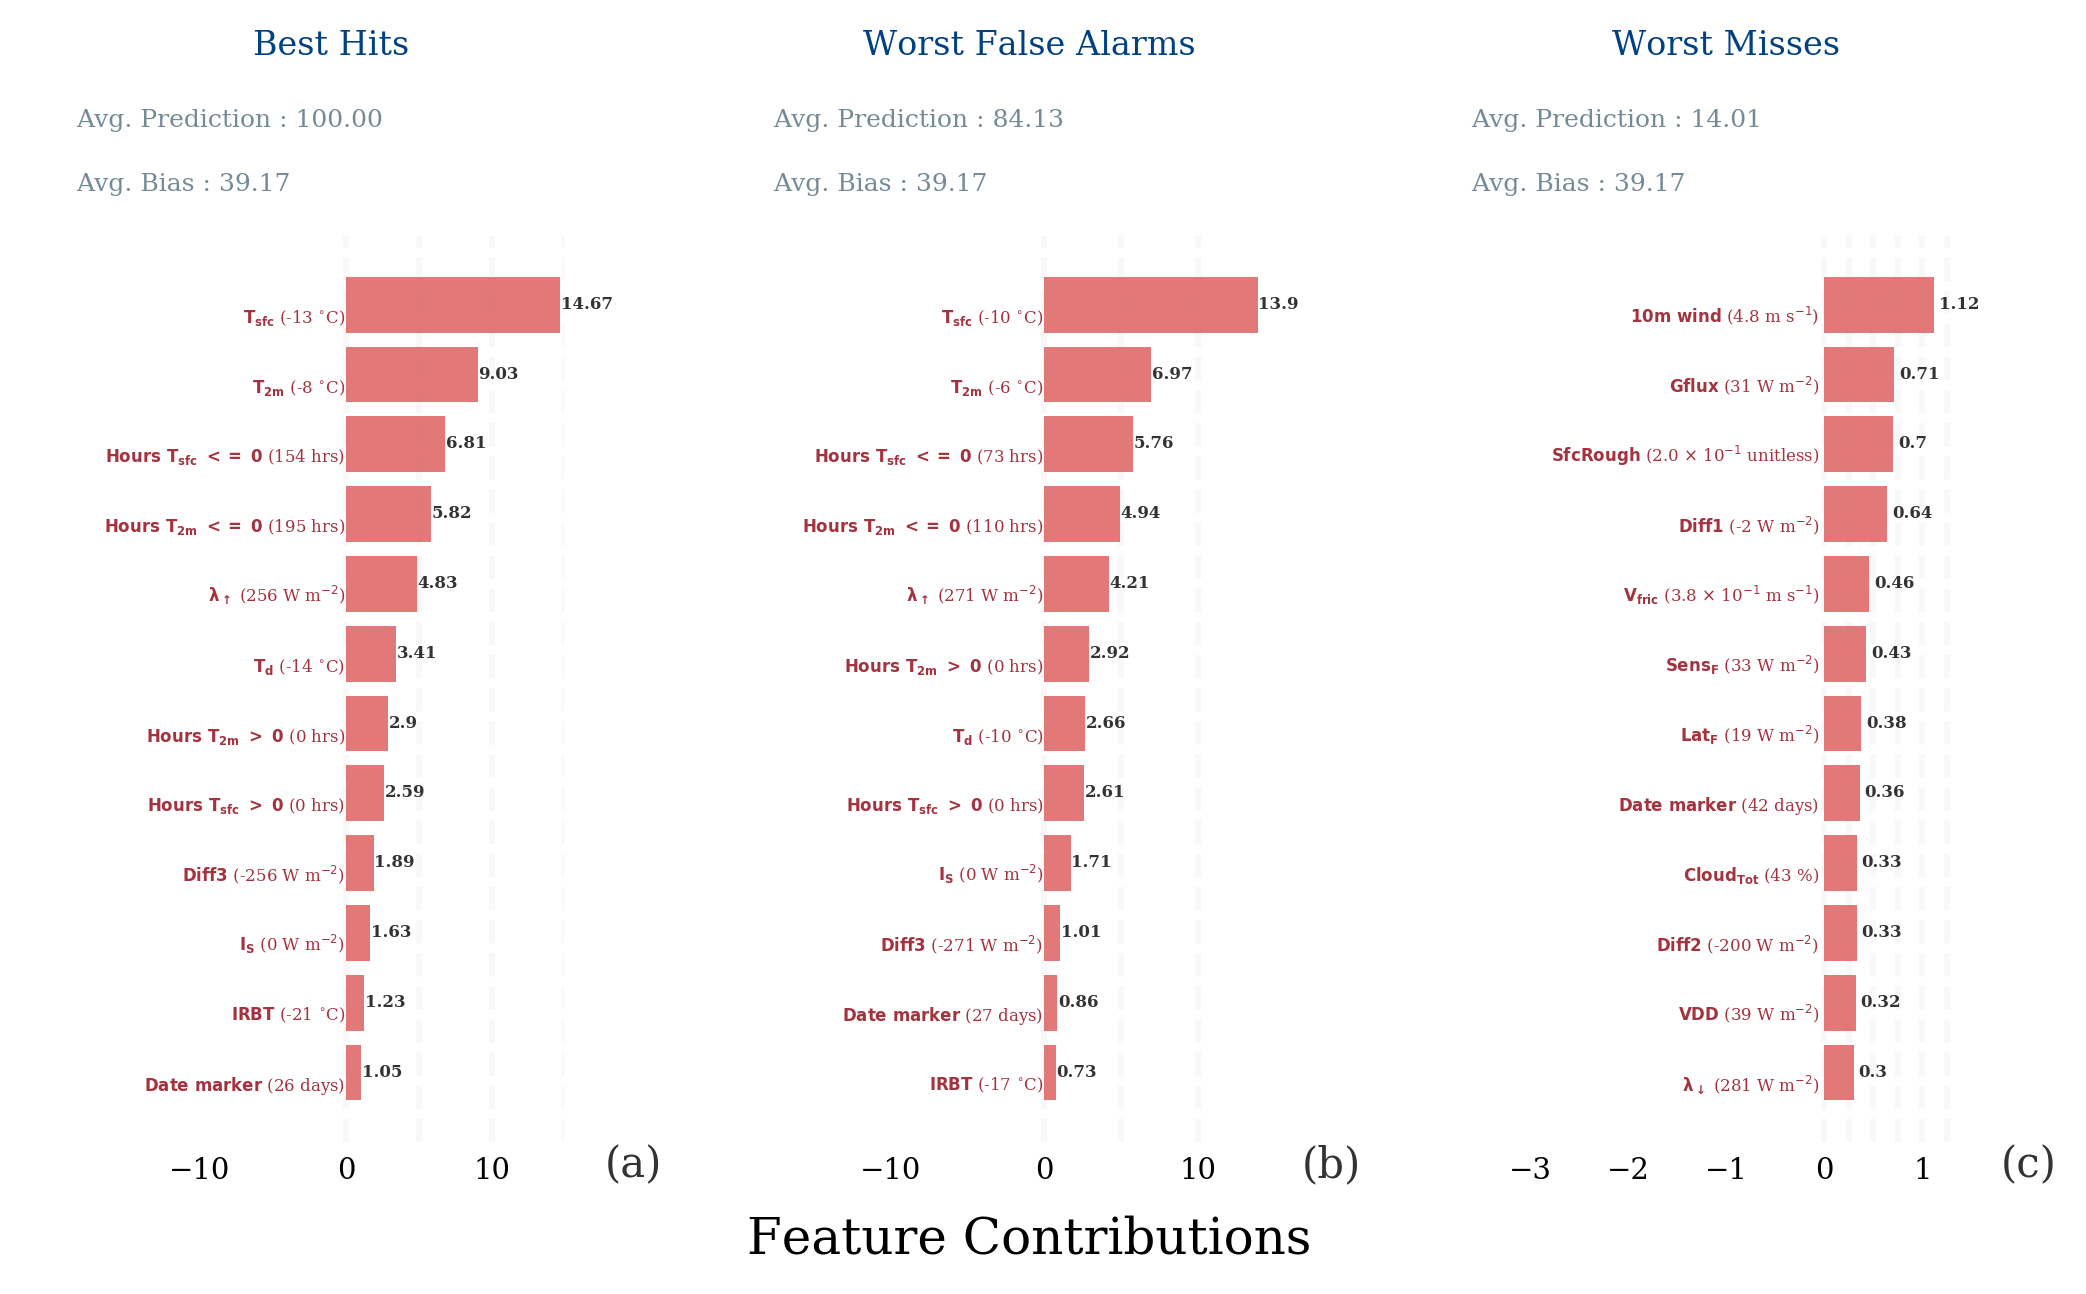

In [7]:
fig, axes = explainer.plot_contributions(
                                            contrib = tree_results,  
                                            display_feature_names=plotting_config.display_feature_names,
                                            display_units = plotting_config.display_units,
                                            perf_keys=perf_keys, other_label=None)

### SHAP-based Feature Contributions (Single Example)

A better method with model-agnostic capabilities is __SHAP (SHapley Additive exPlanations)__(https://github.com/slundberg/shap; https://christophm.github.io/interpretable-ml-book/shap.html). SHAP uses game theoretic approach to explain the output of any machine learning model. 

trying TreeExplainer...
trying TreeExplainer...
trying TreeExplainer...
TreeExplainer failed, starting KernelExplainer...


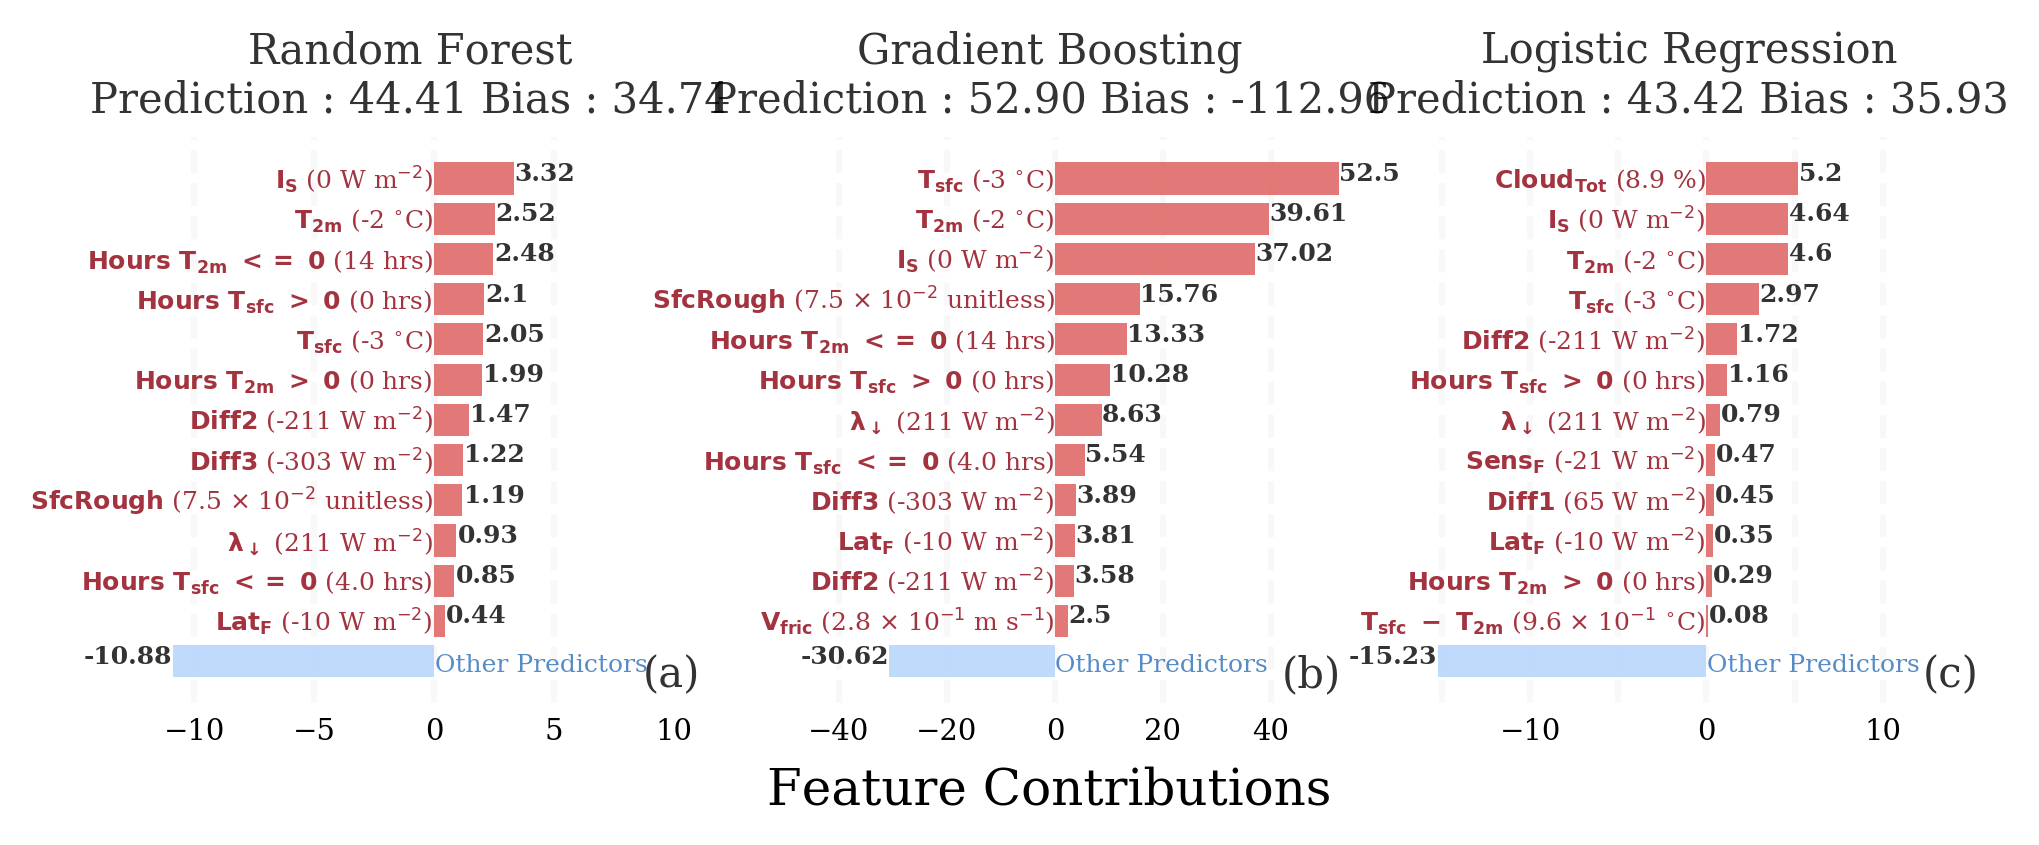

In [8]:
single_example = X.iloc[[0]]
explainer = pymint.InterpretToolkit(estimators,estimator_names=estimator_names, X=single_example,)

background_dataset = shap.sample(X, 100)
results = explainer.local_contributions(method='shap', 
                                       background_dataset=background_dataset)

fig = explainer.plot_contributions(
                                       contrib=results,
                                       to_only_varname=None, 
                                       display_feature_names=plotting_config.display_feature_names,
                                       display_units = plotting_config.display_units,
                                )

### SHAP-based Feature Contributions (Performance-based)

trying TreeExplainer...


100%|===================| 199/200 [00:51<00:00]        

trying TreeExplainer...


 99%|===================| 198/200 [00:46<00:00]        

trying TreeExplainer...


 98%|===================| 196/200 [00:51<00:01]        

trying TreeExplainer...


 98%|===================| 197/200 [00:43<00:00]        

KeyError: 'Least Error Predictions'

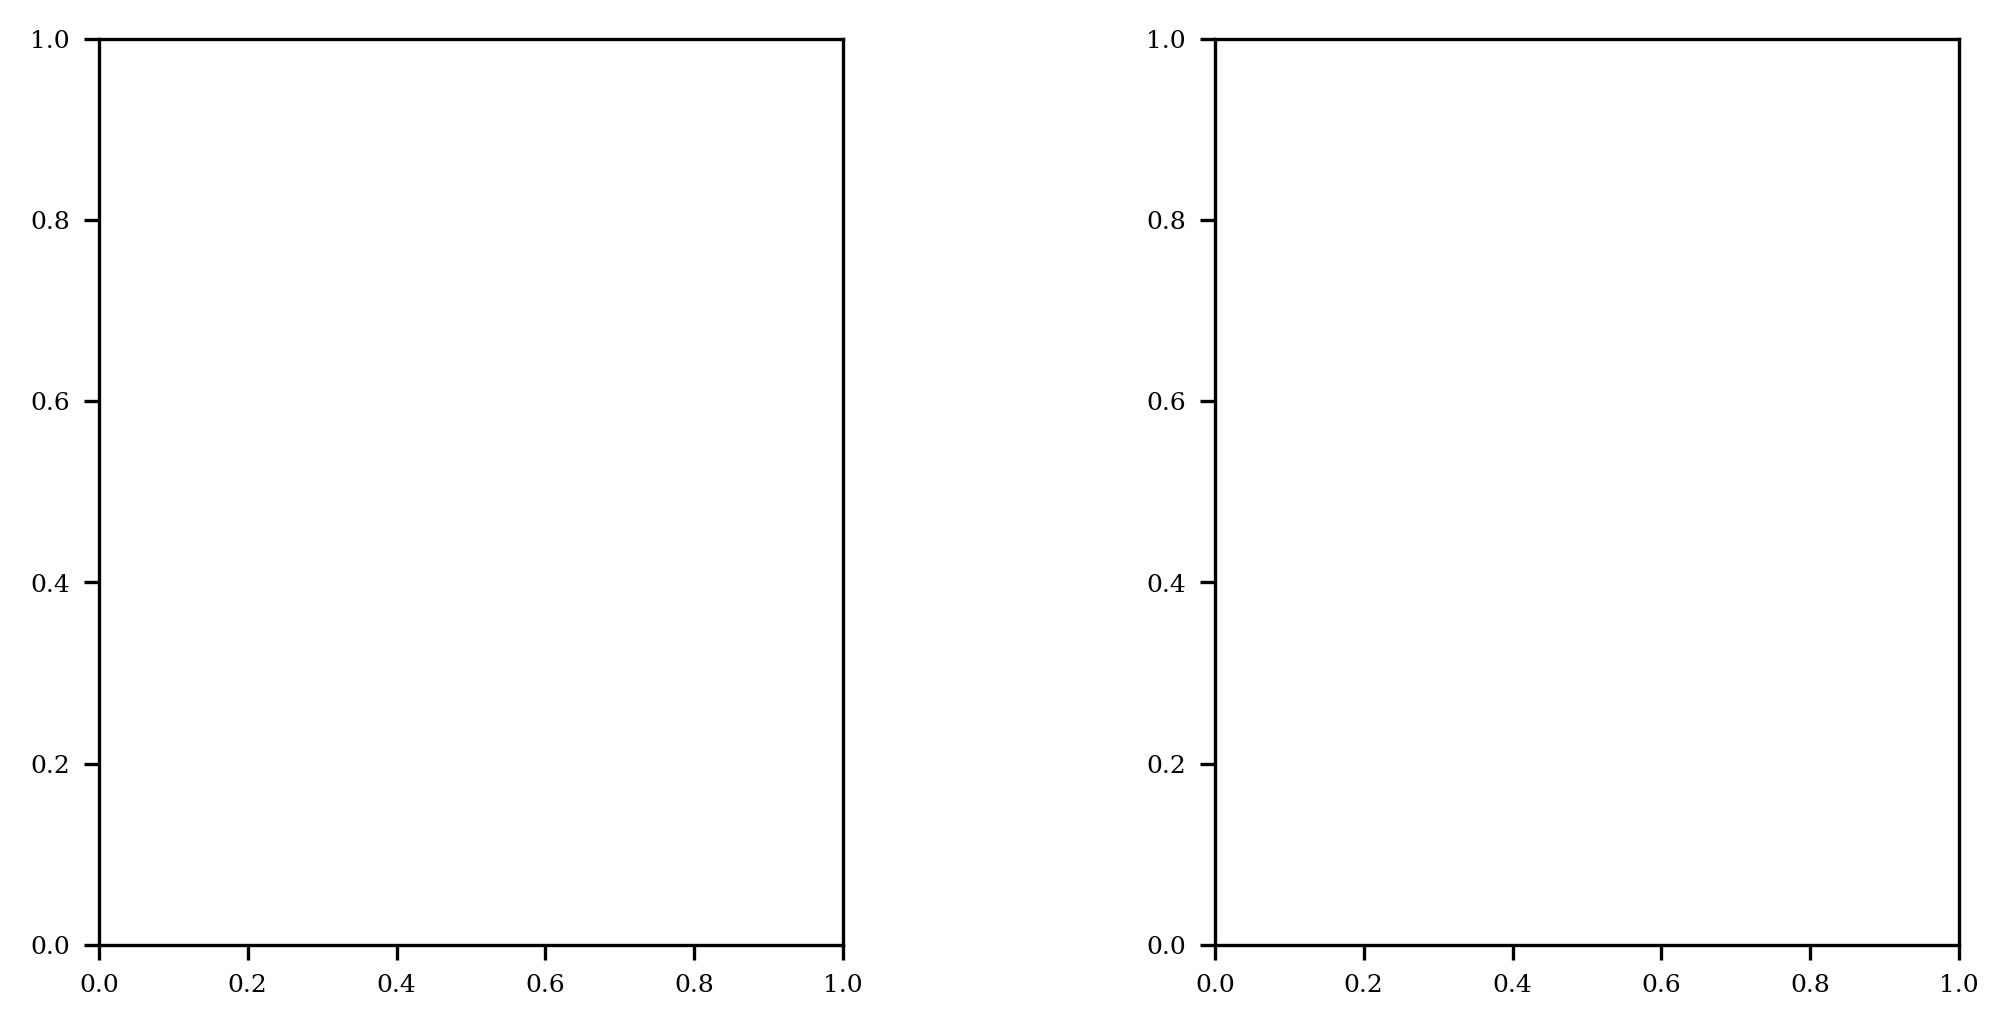

In [9]:
del explainer 
explainer = pymint.InterpretToolkit(estimators[0],estimator_names=estimator_names[0], X=X, y=y)

results = explainer.local_contributions(method='shap', 
                                       background_dataset=background_dataset,
                                       performance_based=True,
                                          )
fig = explainer.plot_contributions(contrib=results, 
                                       to_only_varname=None, 
                                      display_feature_names=plotting_config.display_feature_names,
                                       display_units = plotting_config.display_units,
                                )

## Feature Contributions for Regression Problems

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [ ]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

In [ ]:
explainer = pymint.InterpretToolkit(clf,'Random Forest',X=X,y=y,feature_names = feature_names)

In [ ]:
background_dataset = shap.sample(X, 100)
results = explainer.local_contributions(method='shap', 
                                           background_dataset=background_dataset,
                                           performance_based=True,
                                          )
fig = explainer.plot_contributions(results)